In [1]:
import pandas as pd
data = pd.read_csv(   'https://raw.githubusercontent.com/Garve/datasets/4576d323bf2b66c906d5130d686245ad205505cf/mmm.csv',
    parse_dates=['Date'],
    index_col='Date'
)
X = data.drop(columns=['Sales'])
y = data['Sales']

In [2]:
X

,TV,Radio,Banners
Date,,,
2018-01-07,13528.10,0.00,0.00
2018-01-14,0.00,5349.65,2218.93
2018-01-21,0.00,4235.86,2046.96
2018-01-28,0.00,3562.21,0.00
2018-02-04,0.00,0.00,2187.29
...,...,...,...
2021-10-03,0.00,0.00,1691.68
2021-10-10,11543.58,4615.35,2518.88
2021-10-17,0.00,4556.16,1919.19


In [73]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#from orbit.models import KTR
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
from prophet.utilities import regressor_coefficients
from scipy.ndimage import gaussian_filter
from sklearn.base import BaseEstimator, TransformerMixin
import seaborn as sns
import pymc as pm
#from scipy.stats import pearsonr

plt.style.use('seaborn-poster')
plt.style.use('fivethirtyeight')
plt.rcParams["figure.figsize"] = [8, 4]
plt.rcParams["figure.dpi"] = 100

In [39]:
min_date = pd.to_datetime("2018-04-01")
max_date = pd.to_datetime("2021-09-01")

data_df = pd.DataFrame(
    data={"date": pd.date_range(start=min_date, end=max_date, freq="W-MON")}
)

data_df = data_df.assign(
    year = lambda x: x["date"].dt.year,
    month = lambda x: x["date"].dt.month,
    dayofyear = lambda x: x["date"].dt.dayofyear,
)

n = data_df.shape[0]

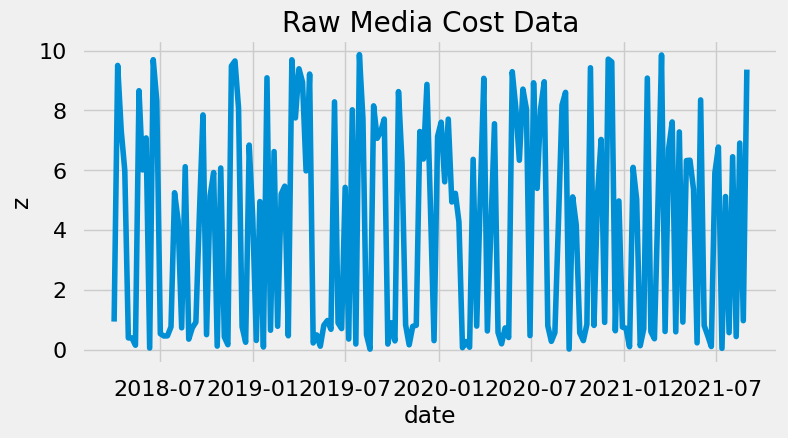

In [40]:
SEED = 42
np.random.seed(SEED)

# sample from a uniform distribution on [0, 1] and cut at the threshold (0.4)
z = np.random.uniform(low=0.0, high=1.0, size=n)
data_df["z"] = 10 * np.where( z > 0.4, z, z/4)

fig, ax = plt.subplots()
sns.lineplot(x="date", y="z", data=data_df, ax=ax)
ax.set(title="Raw Media Cost Data");

In [41]:
class GeometricAdstockTransformer(BaseEstimator, TransformerMixin):

    def __init__(self, alpha: float = 0.0, l: int = 12):
        self.alpha = alpha
        self.l = l

    def fit(self, x, y=None):
        return self

    def transform(self, x):
        if isinstance(x, pd.DataFrame):
            x = x.to_numpy()
        cycles = [
            np.append(
                arr=np.zeros(shape=x.shape)[:i],
                values=x[: x.shape[0] - i],
                axis=0
            ) 
            for i in range(self.l)
        ]
        x_cycle = np.stack(cycles, axis=0)
        w = np.array([np.power(self.alpha, i) for i in range(self.l)])
        return np.tensordot(a=w, b=x_cycle, axes=1)

In [42]:
# the effect carryover factor is 1/2 (usual assumption)
alpha = 1/2
# The carryover period is 12 weeks, which is also quite reasonable.
l = 12 

geometric_adstock_transformer = GeometricAdstockTransformer(alpha=alpha, l=l)

data_df["z_adstock"] = geometric_adstock_transformer.fit_transform(data_df["z"])

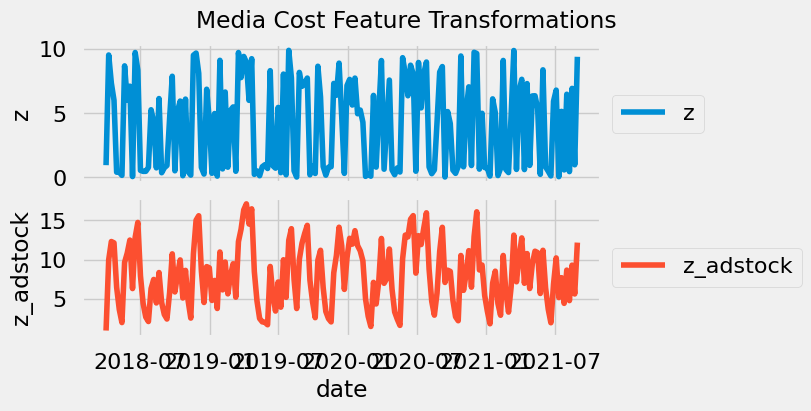

In [43]:
fig, axes = plt.subplots(
  nrows=2,
  ncols=1,
  sharex=True,
  sharey=False,
  layout="constrained"
)

features = ["z", "z_adstock"]

for i, (col, ax) in enumerate(zip(features, axes.flatten())):
    sns.lineplot(x="date", y=col, color=f"C{i}", label=col, data=data_df, ax=ax)
    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))

fig.suptitle("Media Cost Feature Transformations");

In [44]:
class LogisticSaturationTransformer(BaseEstimator, TransformerMixin):

    def __init__(self, mu: float = 0.5):
        self.mu = mu

    def fit(self, x, y=None):
        return self

    def transform(self, x):
        return (1 - np.exp(-self.mu * x)) / (1 + np.exp(-self.mu * x))

In [45]:
mu = 1.5e-1

logistic_saturation_transformer = LogisticSaturationTransformer(mu=mu)

data_df["z_adstock_saturated"] = logistic_saturation_transformer.fit_transform(data_df["z_adstock"])

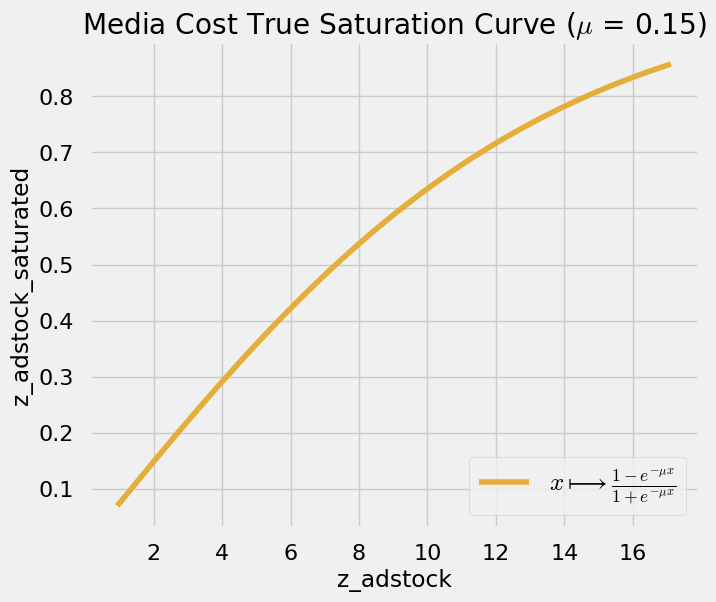

In [46]:
fig, ax = plt.subplots(figsize=(7, 6))

latex_function = r"$x\longmapsto \frac{1 - e^{-\mu x}}{1 + e^{-\mu x}}$"
sns.lineplot(
    x="z_adstock",
    y="z_adstock_saturated",
    color="C2",
    label=latex_function,
    data=data_df,
    ax=ax
)
ax.legend(loc="lower right", prop={"size": 18})
ax.set(title=f"Media Cost True Saturation Curve ($\mu$ = {mu})");

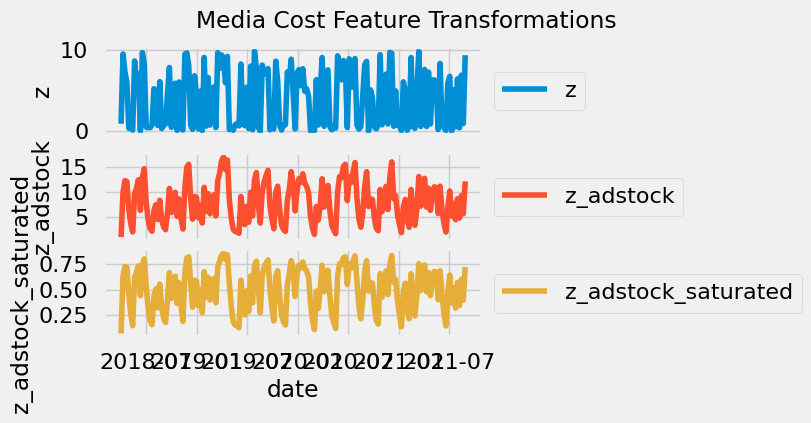

In [47]:
fig, axes = plt.subplots(
  nrows=3,
  ncols=1,
  sharex=True,
  sharey=False,
  layout="constrained"
)

features = ["z", "z_adstock", "z_adstock_saturated"]

for i, (col, ax) in enumerate(zip(features, axes.flatten())):
    sns.lineplot(x="date", y=col, color=f"C{i}", label=col, data=data_df, ax=ax)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

fig.suptitle("Media Cost Feature Transformations");

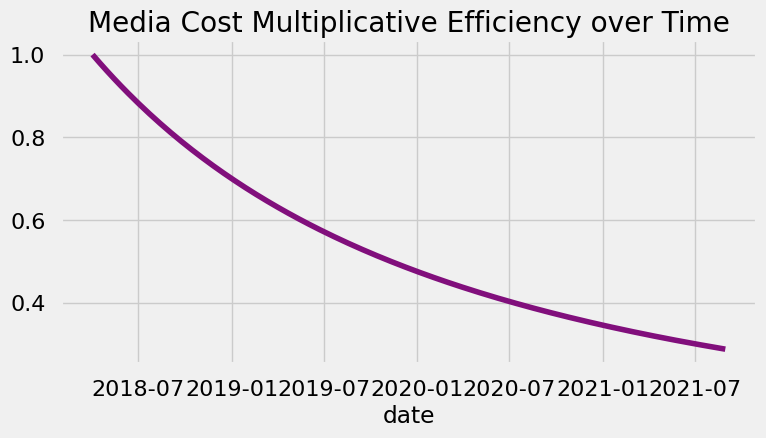

In [48]:
data_df["beta"] =  (np.arange(start=0.0, stop=1.0, step=1/n) + 1) ** (-1.8)

fig, ax = plt.subplots()
sns.lineplot(x="date", y="beta", color="C5", data=data_df, ax=ax)
ax.set(title="Media Cost Multiplicative Efficiency over Time", ylabel=None);

In [49]:
data_df["z_effect"] = data_df["beta"] * data_df["z_adstock_saturated"]


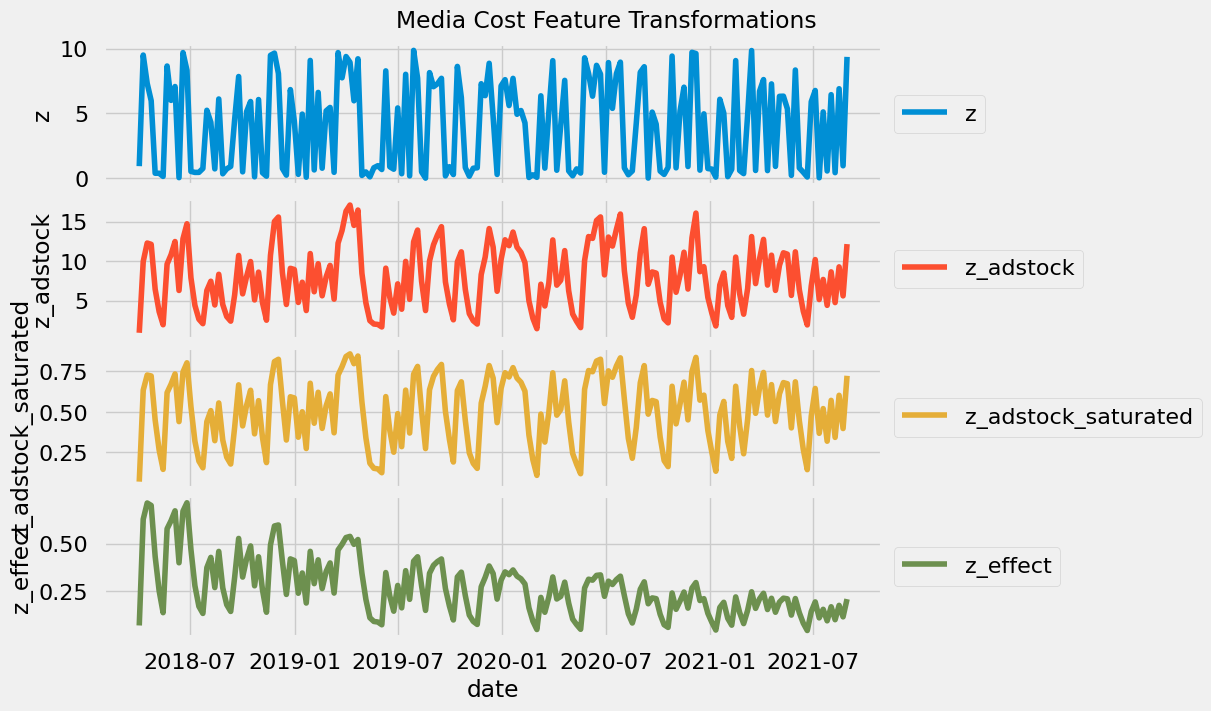

In [50]:
fig, axes = plt.subplots(
    nrows=4,
    ncols=1,
    figsize=(12, 7),
    sharex=True,
    sharey=False,
    layout="constrained"
)

features = ["z", "z_adstock", "z_adstock_saturated", "z_effect"]

for i, (col, ax) in enumerate(zip(features, axes.flatten())):
    sns.lineplot(x="date", y=col, color=f"C{i}", label=col, data=data_df, ax=ax)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

fig.suptitle("Media Cost Feature Transformations");

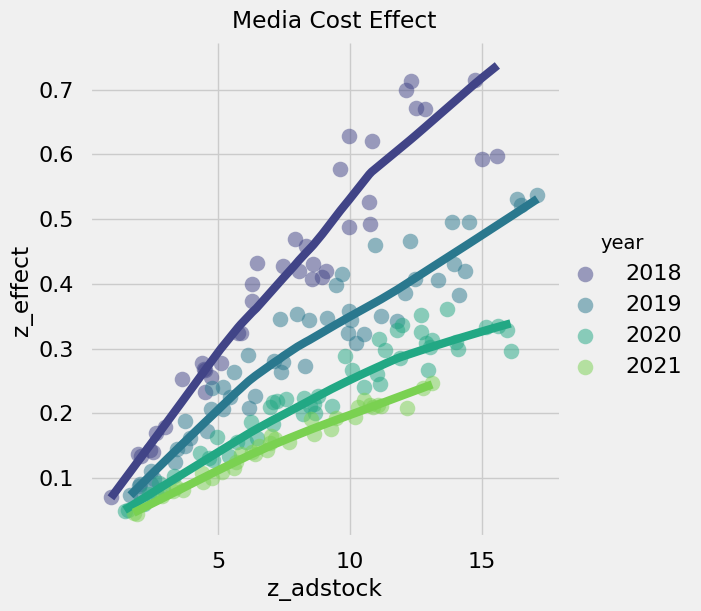

In [52]:
g = sns.lmplot(
    x="z_adstock",
    y="z_effect",
    hue="year",
    palette="viridis",
    lowess=True,
    scatter_kws={"edgecolor": "black", "alpha": 0.5},
    height=6,
    data=data_df
)
g.fig.suptitle("Media Cost Effect", y=1.02);

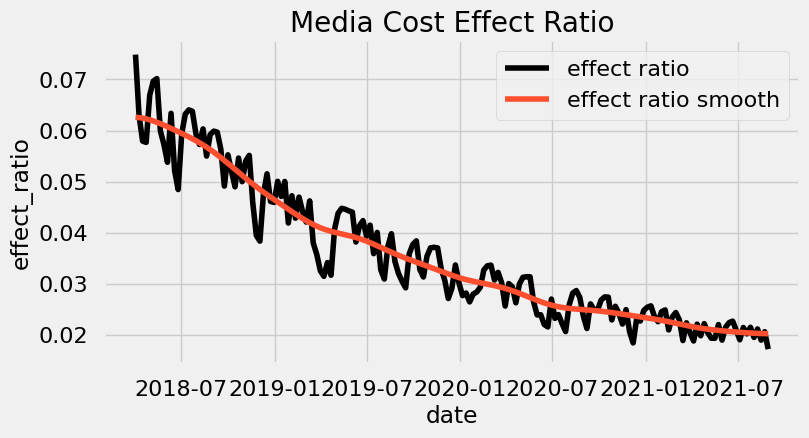

In [53]:
data_df.eval(expr="effect_ratio = z_effect / z_adstock", inplace=True)

data_df["effect_ratio_smooth"] = gaussian_filter(input=data_df["effect_ratio"], sigma=8)

fig, ax = plt.subplots()
sns.lineplot(x="date", y="effect_ratio", color="black", label="effect ratio", data=data_df, ax=ax)
sns.lineplot(x="date", y="effect_ratio_smooth", color="C7", label="effect ratio smooth", data=data_df, ax=ax)
ax.set(title="Media Cost Effect Ratio");

In [54]:
data_df["trend"] = (np.linspace(start=0.0, stop=50, num=n) + 10)**(1/4) - 1 


In [55]:
data_df["trend"] = (np.linspace(start=0.0, stop=50, num=n) + 10)**(1/4) - 1 

In [56]:
data_df["cs"] = - np.sin(2 * 2 * np.pi * data_df["dayofyear"] / 365.5) 
data_df["cc"] = np.cos(1 * 2 * np.pi * data_df["dayofyear"] / 365.5)
data_df["seasonality"] = 0.25 * (data_df["cs"] + data_df["cc"])

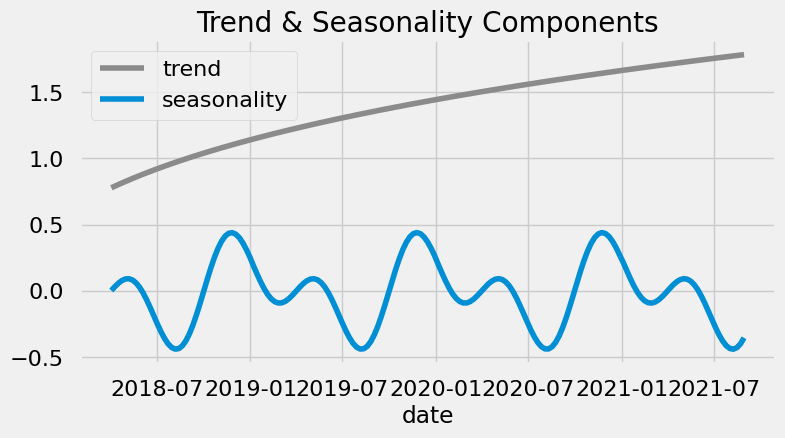

In [57]:
fig, ax = plt.subplots()
sns.lineplot(x="date", y="trend", color="C4", label="trend", data=data_df, ax=ax)
sns.lineplot(x="date", y="seasonality", color="C6", label="seasonality", data=data_df, ax=ax)
ax.legend(loc="upper left")
ax.set(title="Trend & Seasonality Components", ylabel="");

In [58]:
np.random.seed(SEED)

data_df["intercept"] = 3.0
data_df["trend_plus_intercept"] = data_df["trend"] + data_df["intercept"]

# the noise variance is increasing to make sure the resulting time series has constant variance
sigma_epsilon  = np.linspace(start=3e-2, stop=7e-2, num=n)
data_df["epsilon"] = np.random.normal(loc=0.0, scale=sigma_epsilon)

In [59]:
data_df.eval(expr="y = intercept + trend + seasonality + z_effect + epsilon", inplace=True)
data_df.head()

,date,year,month,dayofyear,z,z_adstock,z_adstock_saturated,beta,z_effect,effect_ratio,effect_ratio_smooth,trend,cs,cc,seasonality,intercept,trend_plus_intercept,epsilon,y
0,2018-04-02,2018,4,92,0.936350,0.936350,0.070111,1.000000,0.070111,0.074877,0.062576,0.778279,0.021487,-0.010744,0.002686,3.0,3.778279,0.014901,3.865978
1,2018-04-09,2018,4,99,9.507143,9.975318,0.634043,0.990022,0.627717,0.062927,0.062525,0.790638,0.259165,-0.130704,0.032115,3.0,3.790638,-0.004179,4.446291
2,2018-04-16,2018,4,106,7.319939,12.307599,0.727346,0.980198,0.712944,0.057927,0.062426,0.802746,0.481904,-0.248773,0.058283,3.0,3.802746,0.019722,4.593694
3,2018-04-23,2018,4,113,5.986585,12.140384,0.721386,0.970526,0.700123,0.057669,0.062280,0.814614,0.676865,-0.363245,0.078405,3.0,3.814614,0.046718,4.639861
4,2018-04-30,2018,4,120,0.390047,6.460239,0.449855,0.961000,0.432310,0.066919,0.062093,0.826254,0.832810,-0.472462,0.090087,3.0,3.826254,-0.007235,4.341417


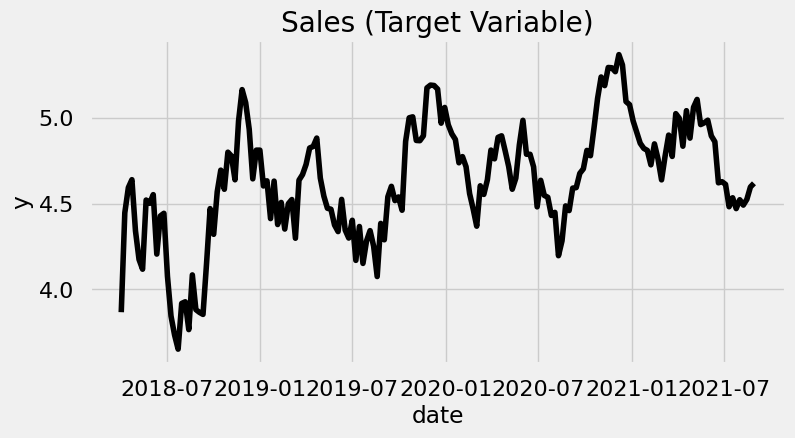

In [60]:
fig, ax = plt.subplots()
sns.lineplot(x="date", y="y", color="black", data=data_df, ax=ax)
ax.set(title="Sales (Target Variable)");

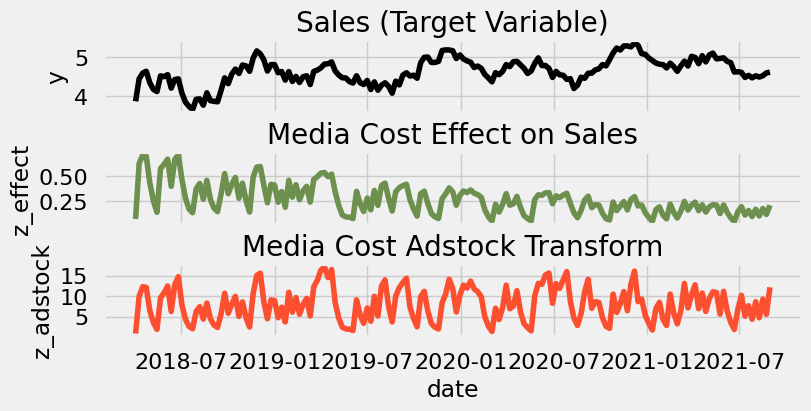

In [61]:
fig, axes = plt.subplots(nrows=3, ncols=1, sharex=True, sharey=False, layout="constrained")
sns.lineplot(x="date", y="y", color="black", data=data_df, ax=axes[0])
axes[0].set(title="Sales (Target Variable)")
sns.lineplot(x="date", y="z_effect", color="C3", data=data_df, ax=axes[1])
axes[1].set(title="Media Cost Effect on Sales")
sns.lineplot(x="date", y="z_adstock", color="C1", data=data_df, ax=axes[2])
axes[2].set(title="Media Cost Adstock Transform");

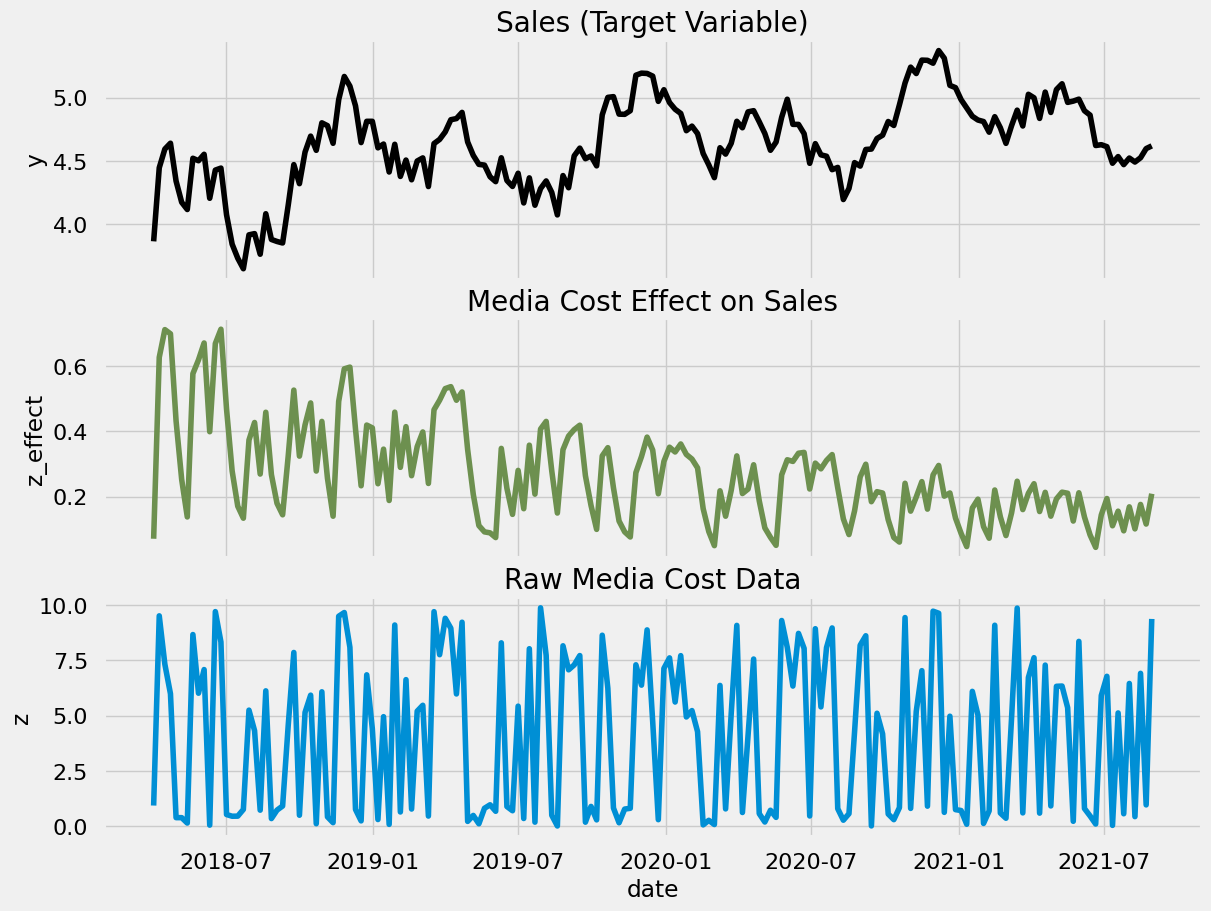

In [62]:
fig, ax = plt.subplots(
    nrows=3,
    ncols=1,
    figsize=(12, 9),
    sharex=True,
    sharey=False,
    layout="constrained"
)
sns.lineplot(x="date", y="y", color="black", data=data_df, ax=ax[0])
ax[0].set(title="Sales (Target Variable)")
sns.lineplot(x="date", y="z_effect", color="C3", data=data_df, ax=ax[1])
ax[1].set(title="Media Cost Effect on Sales")
sns.lineplot(x="date", y="z", data=data_df, ax=ax[2])
ax[2].set(title="Raw Media Cost Data");

In [64]:
columns_to_keep = ["date", "year", "month", "dayofyear", "z", "y"]

df = data_df[columns_to_keep].copy()

In [65]:
t = (df.index - df.index.min()) / (df.index.max() - df.index.min())

In [66]:
n_order = 10
periods = df["dayofyear"] / 365.25
fourier_features = pd.DataFrame(
    {
        f"{func}_order_{order}": getattr(np, func)(2 * np.pi * periods * order)
        for order in range(1, n_order + 1)
        for func in ("sin", "cos")
    }
)

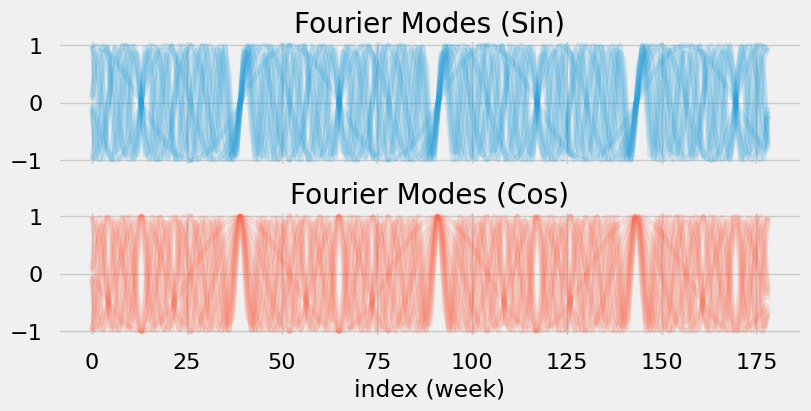

In [67]:
fig, ax = plt.subplots(nrows=2, sharex=True, layout="constrained")
fourier_features.filter(like="sin").plot(color="C0", alpha=0.15, ax=ax[0])
ax[0].get_legend().remove()
ax[0].set(title="Fourier Modes (Sin)", xlabel="index (week)")
fourier_features.filter(like="cos").plot(color="C1", alpha=0.15, ax=ax[1])
ax[1].get_legend().remove()
ax[1].set(title="Fourier Modes (Cos)", xlabel="index (week)");

In [68]:
date = df["date"].values
date_index = df.index
y = df["y"].values
z = df["z"].values
t = t.values

In [74]:
coords = {'fourier_features': np.arange(2 * n_order)}

with pm.Model(check_bounds=False, coords=coords) as base_model:
    # --- priors ---
    ## intercept
    a = pm.Normal("a", mu=0, sigma=0.5)
    ## trend
    b_trend = pm.Normal("b_trend", mu=0, sigma=0.5)
    ## seasonality
    b_fourier = pm.Normal("b_fourier", mu=0, sigma=0.5, dims="fourier_features")
    ## regressor
    b_z = pm.Normal("b_z", mu=0, sigma=2)
    ## standard deviation of the normal likelihood
    sigma = pm.HalfNormal("sigma", sigma=0.1)
    
    # --- model parametrization ---
    trend = pm.Deterministic("trend", a + b_trend * t)
    seasonality = pm.Deterministic(
        "seasonality", pm.math.dot(b_fourier, fourier_features.to_numpy().T)
    )
    z_effect = pm.Deterministic("z_effect", b_z * z)
    mu = trend  + seasonality  + z_effect
    
    # --- likelihood ---
    pm.Normal("likelihood", mu=mu, sigma=sigma, observed=y)
    
    # --- prior samples ---
    base_model_prior_predictive = pm.sample_prior_predictive()

pm.model_to_graphviz(base_model)

ImportError: This function requires the python library graphviz, along with binaries. The easiest way to install all of this is by running

	conda install -c conda-forge python-graphviz